# 3. Preparación de los datos y tarea de regresión

## 3.1 Preparación de los datos

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

# Scikit-learn: preparación de los datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [2]:
df = load_and_info('df_investig_INR.csv')

,Column,Dtype,Missing,Unique,Sample values
0,Unnamed: 0,int64,0,133,"[0, 1, 2, 3, 4]"
1,INR,float64,0,75,"[4.3, 2.8, 2.12, 2.77, 2.36]"
2,CALCI,float64,0,53,"[7.52, 8.54, 2.21, 8.96, 9.12]"
3,HEMOGLOBINA,float64,0,93,"[10.3, 12.24, 8.7, 13.3, 14.0]"
4,VCM,float64,0,105,"[95.7, 103.26, 86.4, 80.6, 95.5]"
5,HEMATOCRIT,float64,0,108,"[31.8, 36.65, 43.2, 40.25, 41.93]"
6,PLAQUETES,float64,0,101,"[192.0, 177.36, 220.0, 200.0, 168.33]"
7,DIAGNÒSTIC_ASSOCIAT,object,0,20,"[FA_NE, Flutter_NE, Valv_Aort_NReum_NE, EP_Oth..."
8,IMC,float64,0,106,"[27.33, 19.751666666666665, 27.425, 24.94, 34.13]"
9,HB_GLICOSILADA_A1C,float64,0,21,"[6.22, 8.0, 6.2, 6.3, 6.5]"



El juego de datos contiene 21 variables y 133 observaciones, de las cuales 0 son duplicadas.


### División en las muestras de entrenamiento, validación, calibración y prueba

In [3]:
target_column = 'INR' 
X = df.drop(columns=[target_column])
y = df[target_column]

# X_train_full: 70% para Entrenamiento y Validación.
# X_test_full: 30% que contiene el Calibración y Prueba (el nuevo set completo de "test").
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.30, random_state=23)

# Paso 2: Dividir el 70% de entrenamiento (X_train_full) -> Entrenamiento (55%) y Validación (15%).
# El set de validación es 15% / 70% ≈ 0.21428 del conjunto X_train_full.
TEST_SIZE_VAL = 0.15 / 0.70

X_train, X_validate, y_train, y_validate = train_test_split(X_train_full, y_train_full, test_size=TEST_SIZE_VAL, random_state=23)

# Dividir el 30% restante de test (X_test_full) -> Calibración (15%) y Prueba (15%).
# Mismo tamaño, por lo que el test_size es 0.5 (la mitad).

# Nota: La convención original era test=20% y cal=80% del 25%, ahora son ambos 50% del 30%.
X_test, X_calibration, y_test, y_calibration = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=23)

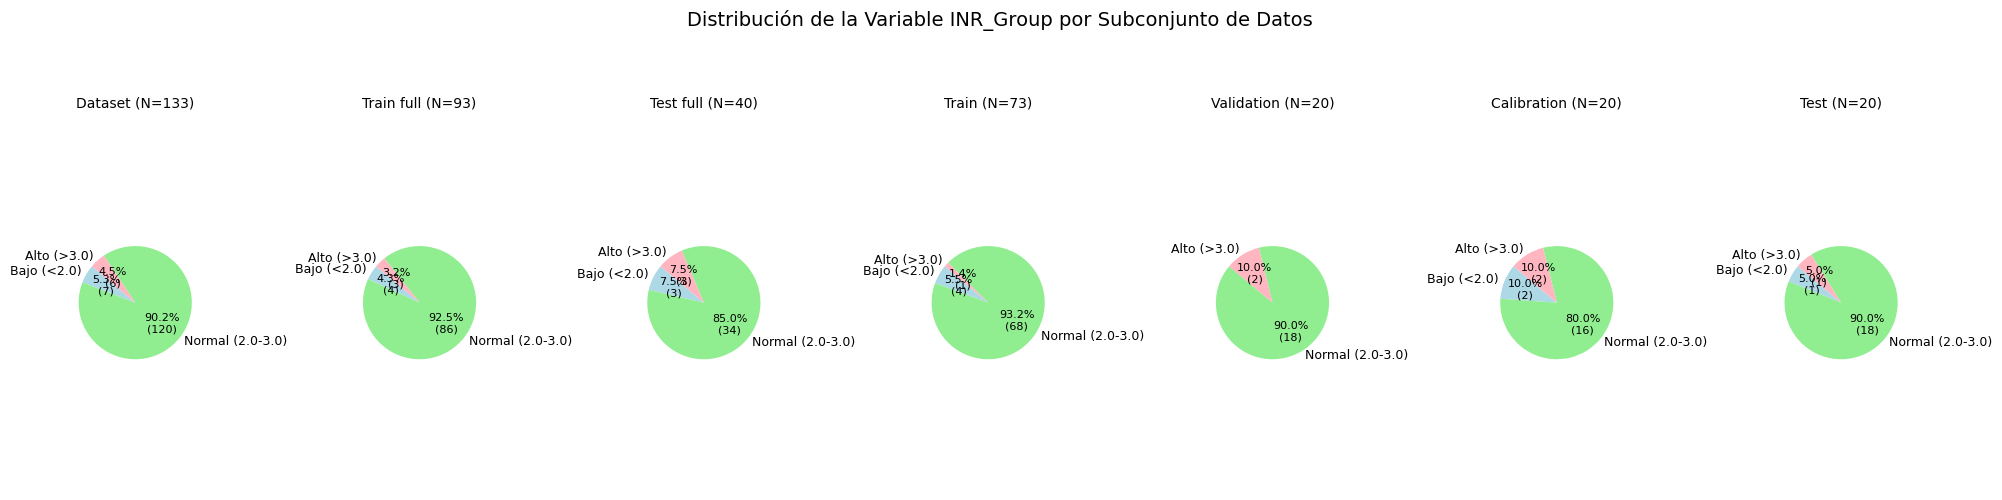

In [4]:
datasets = [df['INR'], y_train_full, y_test_full, y_train, y_validate, y_calibration, y_test]
distribution_INRGrout_Train(datasets)

### Codificación de las variables categóricas

In [5]:
# Listas con los nombres de las columnas categóricas
categorical = df.select_dtypes(exclude ='number').columns.tolist()
print(categorical)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Usar handle_unknown
ohe = ColumnTransformer(
    transformers=[('ohe', encoder, categorical)],
    remainder='passthrough',
    verbose_feature_names_out=False
)
ohe.set_output(transform="pandas")
ohe.fit(X_train) # Ajustamos solo en Entrenamiento

X_train_processed = ohe.transform(X_train)
X_val_processed = ohe.transform(X_validate)
X_test_processed = ohe.transform(X_test)
X_cal_processed = ohe.transform(X_calibration)

['DIAGNÒSTIC_ASSOCIAT']


In [6]:
# Filtramos las columnas que han sido codificadas, esto es, contienen _ en el nombre
encoded_cols = [col for col in X_train_processed.columns if "_" in col]

display(X_train_processed[encoded_cols])

,DIAGNÒSTIC_ASSOCIAT_Anticoagulant_LT,DIAGNÒSTIC_ASSOCIAT_Arritmia_NE,DIAGNÒSTIC_ASSOCIAT_Despol_Prem_Other,DIAGNÒSTIC_ASSOCIAT_EP_Other_No_CorPulm,DIAGNÒSTIC_ASSOCIAT_FA_Cron,DIAGNÒSTIC_ASSOCIAT_FA_NE,DIAGNÒSTIC_ASSOCIAT_FA_Parox,DIAGNÒSTIC_ASSOCIAT_FA_Perm,DIAGNÒSTIC_ASSOCIAT_Flebitis_Profunda,DIAGNÒSTIC_ASSOCIAT_Flutter_NE,...,DIAGNÒSTIC_ASSOCIAT_SPT_NoComp_NE,DIAGNÒSTIC_ASSOCIAT_Sincop,DIAGNÒSTIC_ASSOCIAT_Taquicardia_Parox_NE,DIAGNÒSTIC_ASSOCIAT_Valv_Aort_NReum_NE,HB_GLICOSILADA_A1C,CRIBRATGE_ALIMENTACIÓ,VALORACIÓ_AUDIT_C,NT_PROBNP,CREATINA_KINASA_CK,FREQ_CARDIACA
62,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,66.000000
80,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.40,1.44,0.21,4802.0,63.1,68.200000
23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,2499.0,63.1,79.636364
36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,2.00,0.21,1698.0,63.1,67.461538
103,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,65.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,1.00,1660.5,63.1,65.333333
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,8.30,1.44,0.21,1660.5,63.1,80.800000
21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.00,1660.5,63.1,58.000000
124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,6.22,1.44,0.21,1660.5,63.1,73.500000


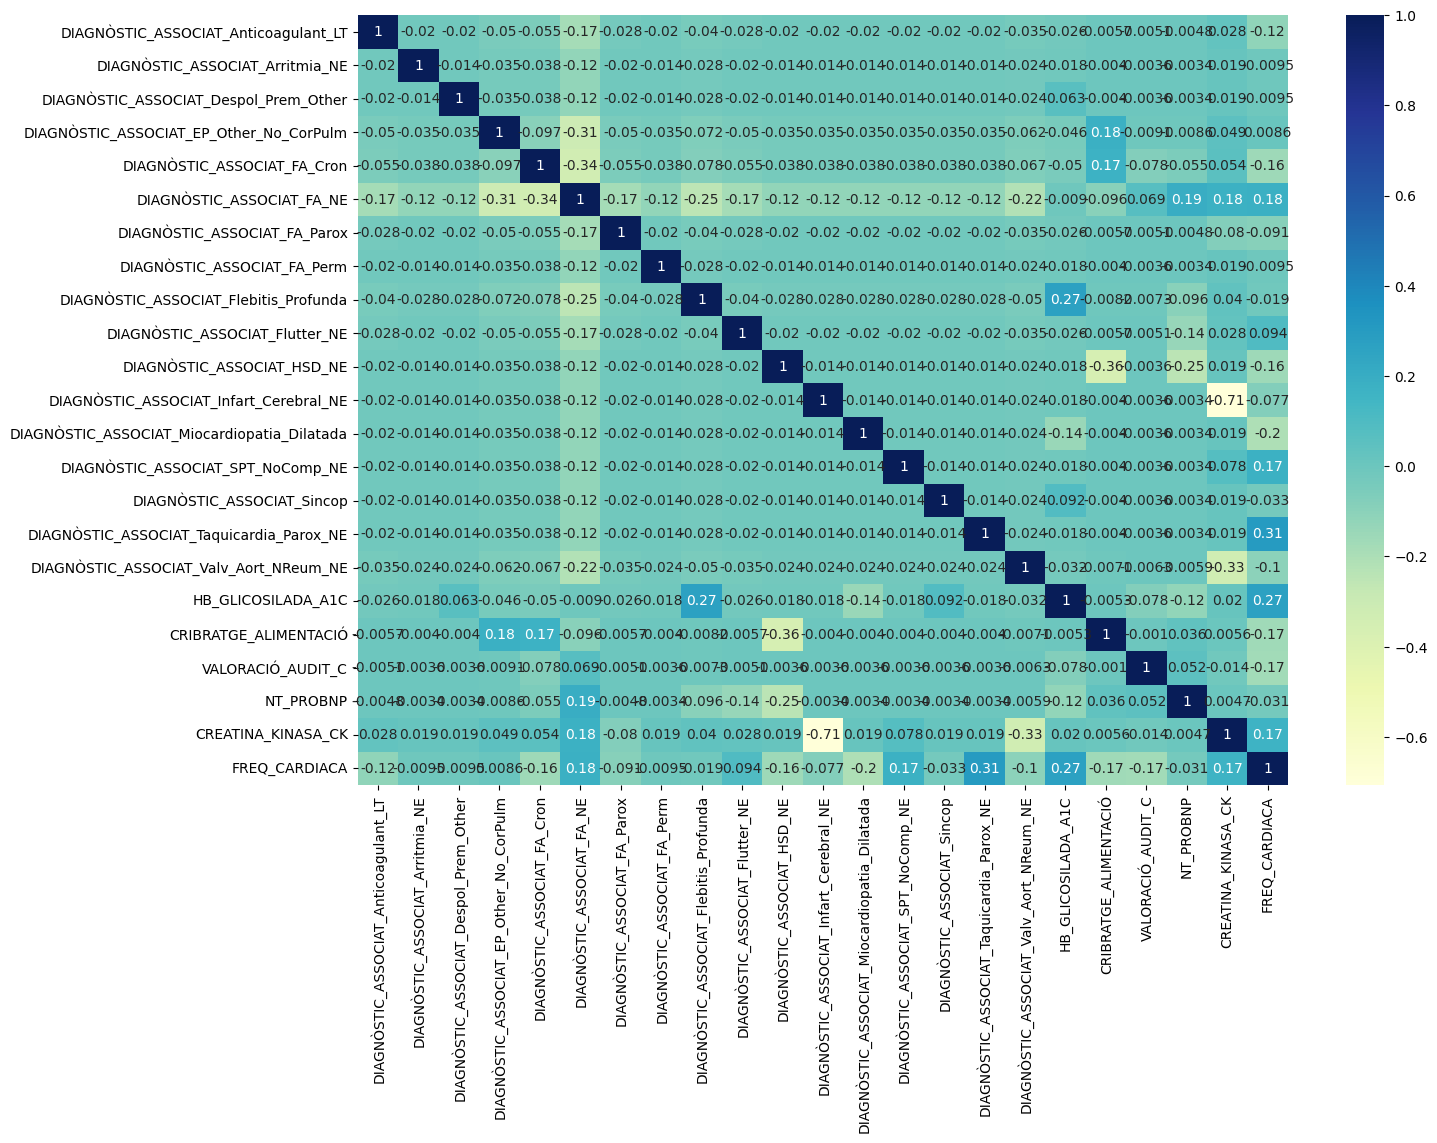

In [7]:
# Análisis de la correlación
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_processed[encoded_cols].corr(), annot=True, cmap="YlGnBu")
plt.show()

Excluímos la información redundante eliminando una de las columnas:

### Imputación de valores ausentes

In [8]:
# Lista con los nombres de las columnas numéricas 
numerical = df.select_dtypes(include = 'number').columns.drop('INR').tolist()

In [9]:
total_ausentes = X_train_full.isnull().sum().sum()
print(f"\nTotal de valores ausentes en todo el set de entrenamiento: {total_ausentes}")


Total de valores ausentes en todo el set de entrenamiento: 0


### Escalado por estandarización

Escalamos ahora las variables numéricas, de modo que se pueda comparar la magnitud de cada característica. Aplicaremos estandarización con StandardScaler(), cuyo método fit() calcula la media y la desviación estándar del conjunto de entrenamiento y transform() se encarga de substraer la primera y dividir por la segunda a cada muestra. Se consigue así que para cada variable la media sea cero y la varianza uno. Este proceso también se acostumbra a llamar normalización, aunque el término puede referirse únicamente a una transformación diferente, como es en la forma de la distribución en vez de en el rango de valores.

In [10]:
# Estandarizamos el conjunto de entrenamiento
scaler = StandardScaler()

# Configuramos ahora ColumnTransformer para evitar las ya codificadas
norm = ColumnTransformer(
    transformers=[('norm', scaler, numerical)],
    remainder='passthrough', # keep any other columns unchanged
    verbose_feature_names_out=False
)
# La salida como dataframe
norm.set_output(transform="pandas")
norm.fit(X_train_processed) # Ajustamos solo en Entrenamiento procesado

X_train_scaled = norm.transform(X_train_processed)
X_val_scaled = norm.transform(X_val_processed) # Transformamos Validación

X_test_scaled = norm.transform(X_test_processed)
X_cal_scaled = norm.transform(X_cal_processed)


# 4. Entrenamiento de los modelos

Random Forest Regressor

In [11]:
# Espacio de búsqueda para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.5, 0.7, 1.0]
}

best = bestHiperparamethers_randomizedSearchCV(param_grid_rf,RandomForestRegressor(random_state=23),X_train_scaled, y_train)


Iniciando ajuste de RandomForestRegressor(random_state=23)...


Mejores parámetros RF: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 15}


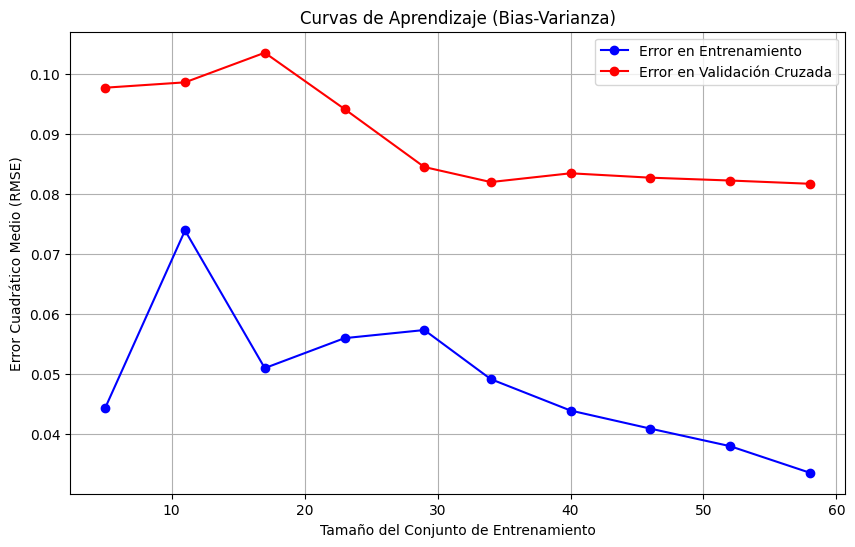

In [12]:
plot_learning_curve(best, X_train_scaled, y_train)

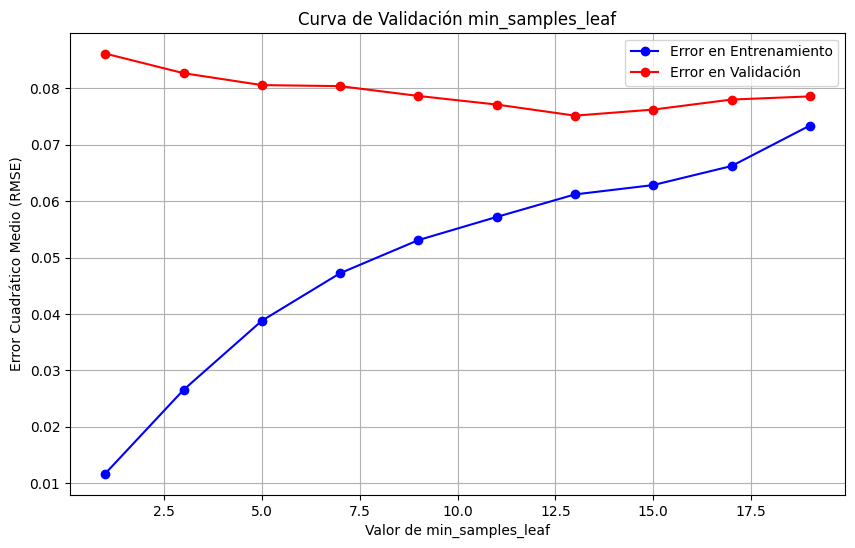

In [13]:


param_range = np.arange(1, 21, 2) 

plot_validation_curve(best, X_train_scaled, y_train,"min_samples_leaf",param_range)


Ajustamos min_samples_leaf al valor mas bajo de la curva de error de validacion

Iniciando ajuste de RandomForestRegressor(random_state=23)...
Mejores parámetros RF: {'n_estimators': 100, 'min_samples_leaf': 13, 'max_features': 0.5, 'max_depth': 15}


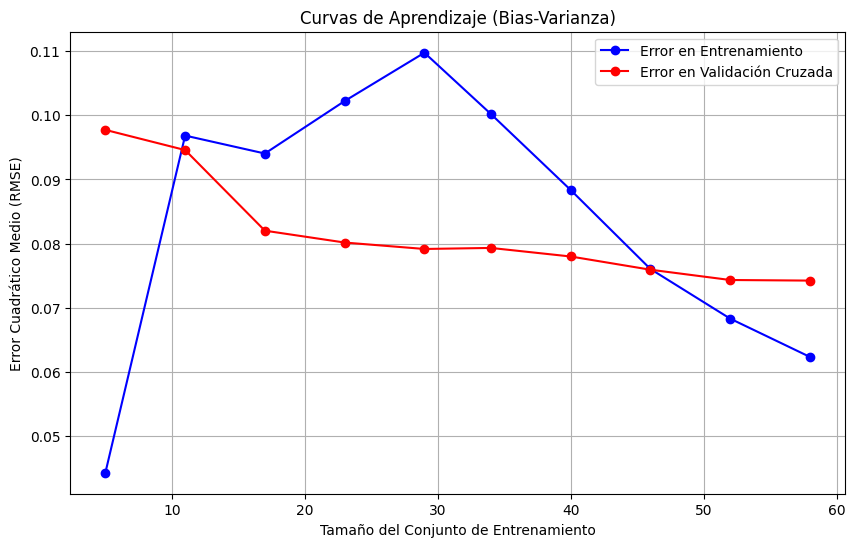

In [14]:

# Espacio de búsqueda para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [13],
    'max_features': [0.5, 0.7, 1.0]
}

rf_best = bestHiperparamethers_randomizedSearchCV(param_grid_rf,RandomForestRegressor(random_state=23),X_train_scaled, y_train)
plot_learning_curve(rf_best, X_train_scaled, y_train)

El modelo ahora muestra un equilibrio mucho mejor entre la capacidad de aprender y la capacidad de generalizar. Las líneas están juntas al final de la curva, indicando que la estructura (min_samples_leaf = 13) es óptima.

XGBoost Regressor

In [15]:

# Espacio de búsqueda para XGBRegressor
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

xgb_best = bestHiperparamethers_randomizedSearchCV(param_grid_xgb,XGBRegressor(random_state=23),X_train_scaled, y_train)


Iniciando ajuste de XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=23, ...)...
Mejores parámetros RF: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}


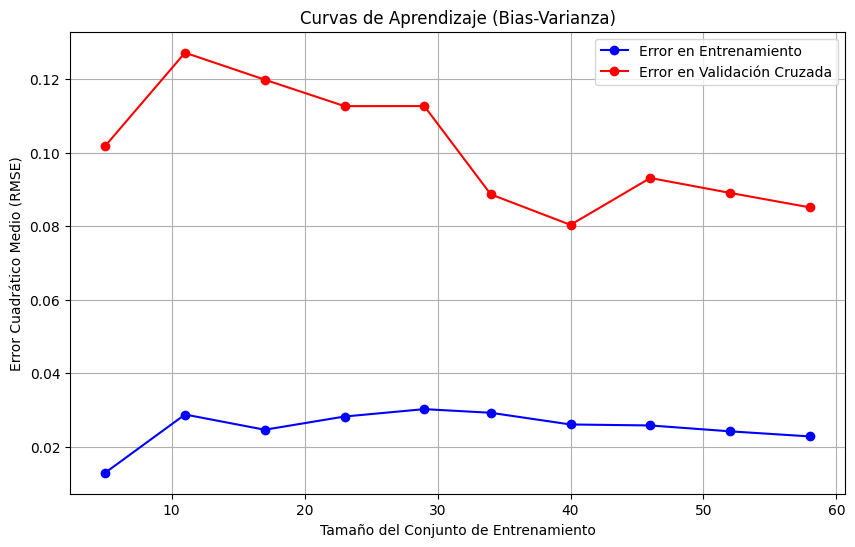

In [16]:
param_range = np.arange(1, 21, 2) 

plot_learning_curve(xgb_best, X_train_scaled, y_train)

¡Exacto! Disminuir el learning_rate (tasa de aprendizaje) es la acción correcta para regularizar el modelo y corregir esa alta varianza que vemos en la curva

⚙️ El Trade-off en XGBoost
Debes recordar un aspecto clave del boosting:

Si disminuyes el learning_rate, debes incrementar el número de estimadores (n_estimators).

Esto se debe a que, si cada árbol contribuye menos (tasa de aprendizaje baja), necesitas más árboles para alcanzar la misma capacidad predictiva.

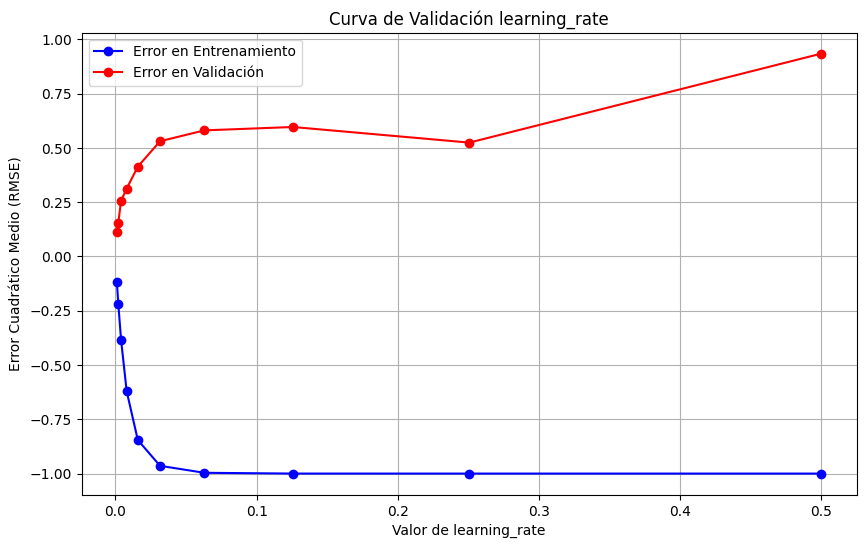

In [17]:

param_range_lr = np.logspace(-3, np.log10(0.5), 10)

plot_validation_curve_boosting(xgb_best, X_train_scaled, y_train,"learning_rate",param_range_lr)

In [18]:

# Espacio de búsqueda para Random Forest
param_grid_xgb = {
    'n_estimators': [500, 2000],
    'learning_rate': [0.005, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10, 15, 20]
}

xgb_best = bestHiperparamethers_randomizedSearchCV(param_grid_xgb,XGBRegressor(random_state=23),X_train_scaled, y_train)

Iniciando ajuste de XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=23, ...)...


Mejores parámetros RF: {'n_estimators': 500, 'min_child_weight': 20, 'max_depth': 3, 'learning_rate': 0.005}


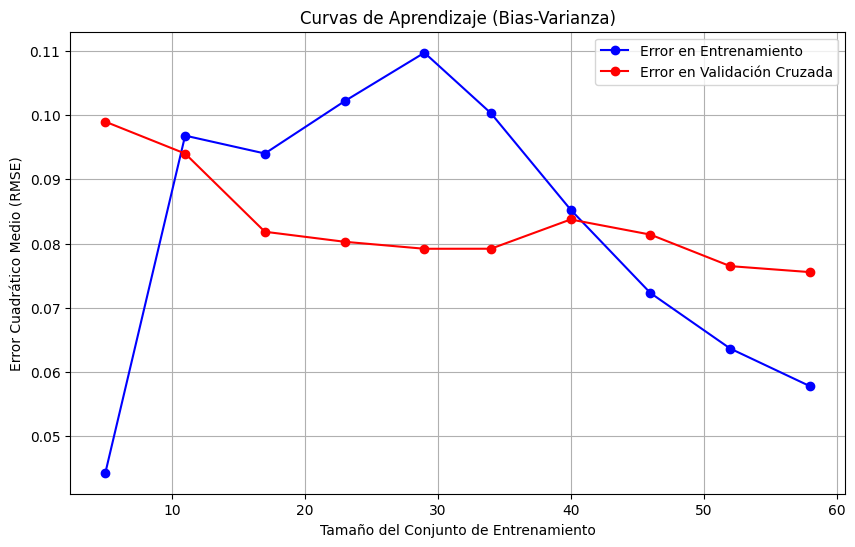

In [19]:
param_range = np.arange(1, 21, 2) 

plot_learning_curve(xgb_best, X_train_scaled, y_train)

CatBoostRegressor

In [20]:
from catboost import CatBoostRegressor
# Espacio de búsqueda para Random Forest
param_grid_cat = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
}

cat_best = bestHiperparamethers_randomizedSearchCV(param_grid_cat,CatBoostRegressor(random_state=23, verbose=0, loss_function='RMSE'),X_train_scaled, y_train)

Iniciando ajuste de <catboost.core.CatBoostRegressor object at 0x0000027434CF18E0>...


c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parámetros RF: {'learning_rate': 0.01, 'depth': 6}


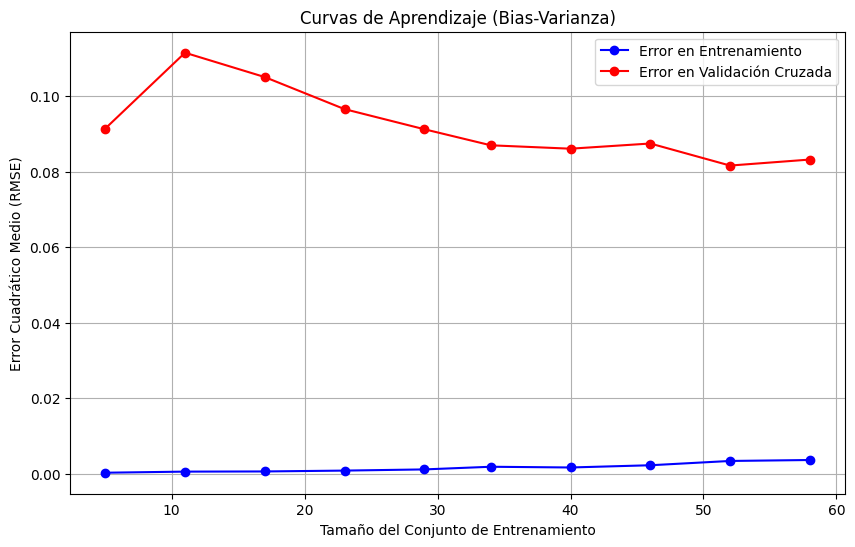

In [21]:
param_range = np.arange(1, 21, 2) 

plot_learning_curve(cat_best, X_train_scaled, y_train)

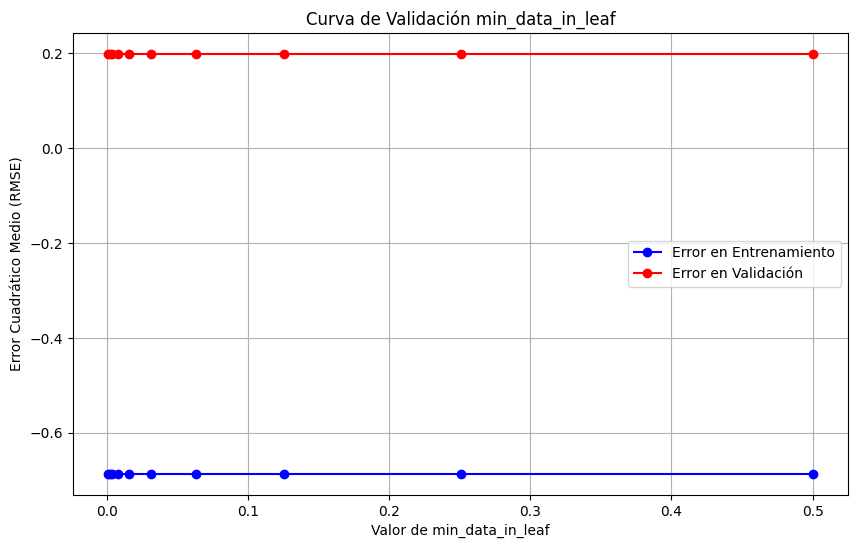

In [ ]:
param_range_lr = np.logspace(-3, np.log10(0.5), 10)

plot_validation_curve_boosting(cat_best, X_train_scaled, y_train,"learning_rate",param_range_lr)

In [34]:
from catboost import CatBoostRegressor
# Espacio de búsqueda para CatBoostRegressor
param_grid_cat = {
    'learning_rate': [0.005, 0.01],
    'depth': [4, 6, 8],
    'min_data_in_leaf': [5, 10, 15],
}

cat_best = bestHiperparamethers_randomizedSearchCV(param_grid_cat,CatBoostRegressor(random_state=23, verbose=0, loss_function='RMSE'),X_train_scaled, y_train)

Iniciando ajuste de <catboost.core.CatBoostRegressor object at 0x0000027434FD0310>...
Mejores parámetros RF: {'min_data_in_leaf': 5, 'learning_rate': 0.005, 'depth': 4}


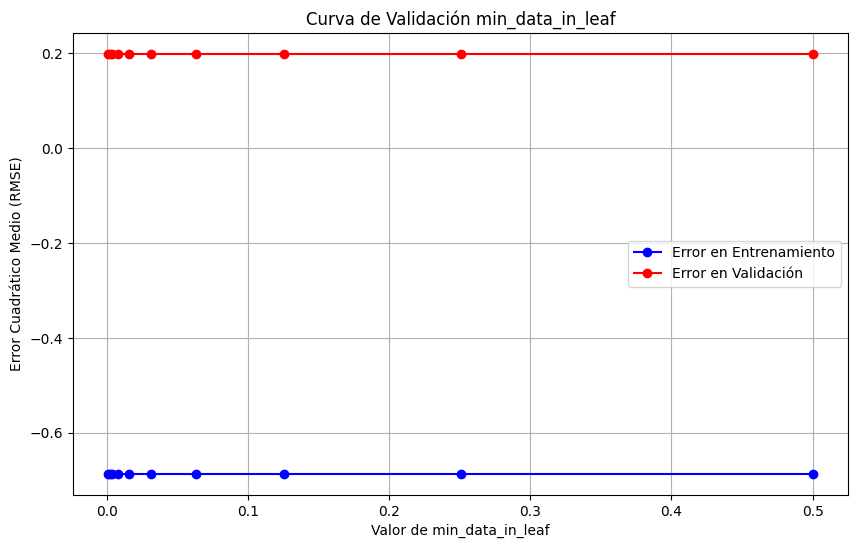

In [35]:
param_range_lr = np.logspace(-3, np.log10(0.5), 10)

plot_validation_curve_boosting(cat_best, X_train_scaled, y_train,"min_data_in_leaf",param_range_lr)

Vemos que min_data_in_leaf no tiene variacion entre el rango buscaremos el l2_leaf_reg optimo

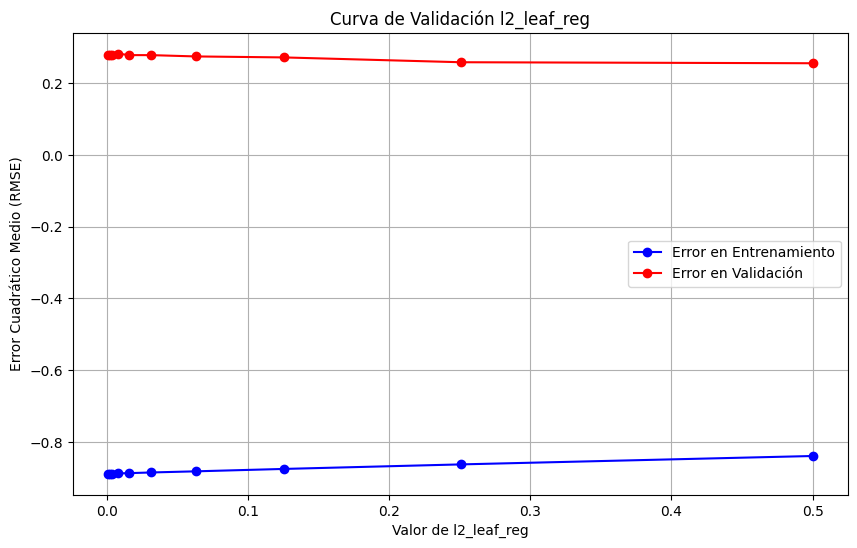

In [37]:
param_range_lr = np.logspace(-3, np.log10(0.5), 10)

plot_validation_curve_boosting(cat_best, X_train_scaled, y_train,"l2_leaf_reg",param_range_lr)

El problema de varianza persiste: La línea azul (entrenamiento) sigue estando muy por debajo de la línea roja (validación), lo que confirma que el sobreajuste es un problema de fondo difícil de eliminar sin un tuning más amplio.

## Evaluación Final para Selección de Modelo

In [42]:
# Asumiendo que has definido los modelos:
# rf_best = search_rf.best_estimator_
# xgb_best = search_xgb.best_estimator_
# cat_best = search_cat.best_estimator_

def evaluar_y_comparar_final(modelos, nombres, X_test, y_test):
    """
    Evalúa una lista de modelos en el conjunto de prueba (X_test, y_test)
    y retorna un DataFrame con las métricas de comparación.
    """
    
    # 1. Inicializar el diccionario para almacenar los resultados
    resultados = {}
    
    # 2. Iterar sobre cada modelo para predecir y evaluar
    for nombre, modelo in zip(nombres, modelos):
        
        # --- CORRECCIÓN CLAVE ---
        # El modelo DEBE generar predicciones antes de evaluar las métricas.
        y_pred = modelo.predict(X_test) 
        
        # Llamamos a tu función evaluate_model con los argumentos correctos:
        # (y_true=y_test, y_pred=y_pred, model_name=nombre)
        metricas = evaluate_model(y_test, y_pred, nombre)
        
        # Almacenar las métricas
        resultados[nombre] = metricas
        
    # 3. Retornar el resultado en un DataFrame de Pandas
    return pd.DataFrame(resultados).T

In [49]:
def plot_comparativa_final(df):
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    metrics = ['R2', 'RMSE', 'MAE']
    titles = ['R² (cerca de 1)', 'RMSE (cerca de 0)', 'MAE (cerca de 0)']
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        bars = ax.bar(df.index, df[metric], color='skyblue')
        
        # Destacar al ganador (Máximo para R2, Mínimo para RMSE/MAE)
        if metric == 'R2':
            winner = df[metric].idxmax()
            criteria = 'max'
        else:
            winner = df[metric].idxmin()
            criteria = 'min'
            
        # Pintar la barra ganadora de color rojo para resaltarla
        winner_index = df.index.get_loc(winner)
        bars[winner_index].set_color('red')
        
        # Añadir etiquetas de valor
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, 
                    yval * (0.95 if yval < 0 else 1.05), # Ajuste para textos negativos
                    f'{yval:.3f}', ha='center', va='center', fontsize=9, color='black')

        ax.set_title(titles[i], fontsize=14)
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--')
        
    plt.tight_layout()
    plt.show()

--- Evaluación: Random Forest ---
R² (Coeficiente de Determinación): -0.0739
RMSE (Error Cuadrático Medio): 0.2972
MAE (Error Absoluto Medio): 0.2372
--- Evaluación: XGBoost ---
R² (Coeficiente de Determinación): 0.0697
RMSE (Error Cuadrático Medio): 0.2766
MAE (Error Absoluto Medio): 0.2189
--- Evaluación: CatBoost ---
R² (Coeficiente de Determinación): -0.1523
RMSE (Error Cuadrático Medio): 0.3079
MAE (Error Absoluto Medio): 0.2334


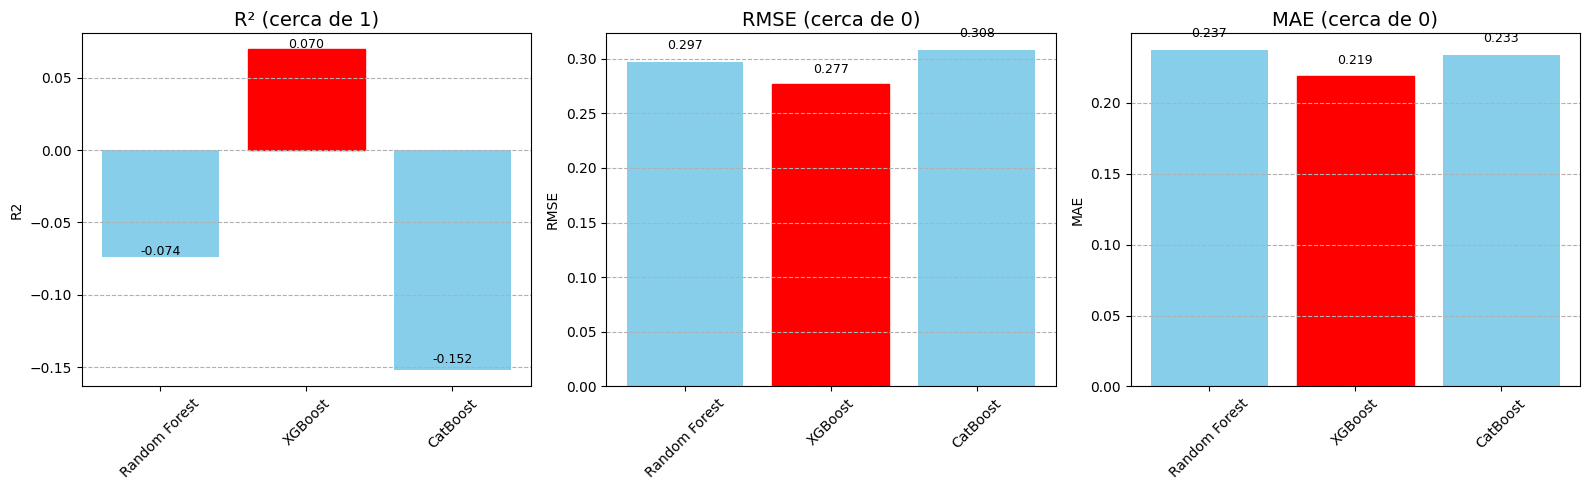

In [50]:
# 1. Crear las listas de modelos y nombres
modelos_finales = [rf_best, xgb_best, cat_best]
nombres_modelos = ['Random Forest', 'XGBoost', 'CatBoost']

# 2. Ejecutar la función para obtener la tabla de comparación
# Usamos el set de PRUEBA (X_test, y_test) para la evaluación final imparcial.
tabla_final_comparativa = evaluar_y_comparar_final(
    modelos=modelos_finales,
    nombres=nombres_modelos,
    X_test=X_test_scaled,
    y_test=y_test
)



plot_comparativa_final(tabla_final_comparativa)

Para elegir el mejor modelo, buscamos:Mayor $R^2$ (cerca de 1.0).Menor RMSE y MAE (cerca de 0).Modelo Ganador: El modelo XGBoost es claramente el ganador, ya que tiene el $R^2$ más alto y el error (RMSE y MAE) más bajo.Rendimiento General: Las métricas de $R^2$ son muy bajas, e incluso negativas para Random Forest y CatBoost. Un $R^2$ negativo significa que el modelo está funcionando peor que simplemente predecir la media de la variable objetivo. El $R^2$ de $0.069$ en XGBoost significa que solo explica alrededor del $7\%$ de la varianza en los datos.

**GANADOR XGBoost**

nterpretación de Resultados UQCobertura Empírica (1.0000): Esto es ideal, pero demasiado bueno. Significa que el $100\%$ de los valores reales en el set de prueba cayeron dentro de los intervalos de predicción. Esto garantiza una fiabilidad perfecta, cumpliendo con creces el objetivo del $95\%$.Ancho Promedio (2.9126): Este es un intervalo muy amplio, lo cual es la razón de la cobertura del $100\%$. Existe una relación de intercambio (trade-off) entre fiabilidad (cobertura) y precisión (ancho). El modelo ha sido muy conservador en la calibración, lo que hace que la predicción sea menos precisa, aunque más confiable.Hemos completado el ciclo de modelado y UQ. Ahora sabemos que nuestro modelo XGBoost genera predicciones muy confiables (aunque poco precisas).El último paso en la construcción de un modelo de IA Confiable para un contexto médico es la Explicabilidad (XAI).